In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 80 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 100
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 50000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

5000000000.0


In [7]:
Eb

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.    ])

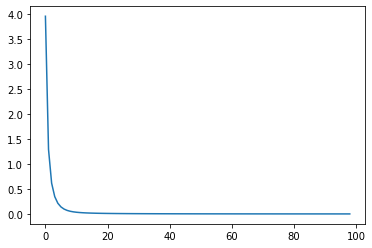

In [8]:
plt.plot(S)

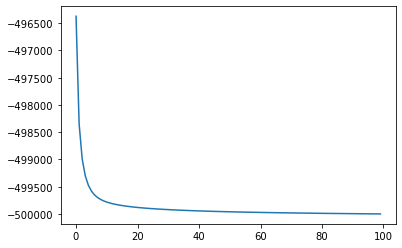

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0009765367463696748

In [11]:
eta

array([-496371.29669918, -498346.50926076, -498991.22167816,
       -499298.93634449, -499472.15978902, -499579.19463783,
       -499649.68172503, -499698.54598198, -499734.01938946,
       -499760.89032002, -499782.03378946, -499799.22053651,
       -499813.57184262, -499825.82029158, -499836.46046185,
       -499845.83712693, -499854.19793456, -499861.72567525,
       -499868.5585962 , -499874.80354513, -499880.54470143,
       -499885.84952116, -499890.7728786 , -499895.36001252,
       -499899.64866326, -499903.67065017, -499907.45305527,
       -499911.01912454, -499914.38896369, -499917.58008218,
       -499920.60782337, -499923.48570844, -499926.22571404,
       -499928.83849845, -499931.33358752, -499933.71952857,
       -499936.00401879, -499938.19401315, -499940.29581553,
       -499942.31515626, -499944.25725839, -499946.12689461,
       -499947.92843643, -499949.66589683, -499951.34296738,
       -499952.9630507 , -499954.52928899, -499956.04458908,
       -499957.51164465,

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([3.62810361e+03, 1.65289105e+03, 1.00817864e+03, 7.00463969e+02,
       5.27240525e+02, 4.20205676e+02, 3.49718589e+02, 3.00854332e+02,
       2.65380924e+02, 2.38509994e+02, 2.17366524e+02, 2.00179777e+02,
       1.85828471e+02, 1.73580022e+02, 1.62939852e+02, 1.53563187e+02,
       1.45202379e+02, 1.37674638e+02, 1.30841717e+02, 1.24596768e+02,
       1.18855612e+02, 1.13550792e+02, 1.08627435e+02, 1.04040301e+02,
       9.97516504e+01, 9.57296635e+01, 9.19472583e+01, 8.83811891e+01,
       8.50113499e+01, 8.18202314e+01, 7.87924903e+01, 7.59146052e+01,
       7.31745996e+01, 7.05618152e+01, 6.80667261e+01, 6.56807851e+01,
       6.33962948e+01, 6.12063005e+01, 5.91044981e+01, 5.70851574e+01,
       5.51430552e+01, 5.32734190e+01, 5.14718772e+01, 4.97344168e+01,
       4.80573462e+01, 4.64372629e+01, 4.48710246e+01, 4.33557245e+01,
       4.18886690e+01, 4.04673578e+01, 3.90894670e+01, 3.77528330e+01,
       3.64554389e+01, 3.51954018e+01, 3.39709620e+01, 3.27804724e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_3p.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_3p.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_3p.csv', S, delimiter = ',')

In [15]:
# calc width

b = (kb * Q[1:] * S**(7/6)) / (D**(3/2))

np.savetxt('width csv files/b_exp_3p.csv', b, delimiter = ',')
np.savetxt('Qs csv files/Qs_exp_3p.csv', Qs, delimiter = ',')